In [1]:
%reload_ext autoreload
%autoreload 2

import os.path
import sys
import pandas as pd
import matplotlib.pyplot as plt

PARENT_DIR = r'D:\projects\diverters\src'
CURR_DIR = os.path.join(PARENT_DIR, 'analysis_v2')
sys.path.append(PARENT_DIR)

from analysis_v2.solve import solve_fixed
from analysis_v2 import config
from parametric_solver.solver import NodeContext
from linearization import surface

In [13]:
solver = solve_fixed()

nodeContext = NodeContext(r"D:\projects\diverters\src\conductivity_effect\in\kdoped_rhenium_high.inp")
nodeContext.add_component('cool_surf1')
nodeContext.add_component('cool_surf2')
nodeContext.run()

press_bound_df = pd.concat([nodeContext.result('cool_surf1'), (nodeContext.result('cool_surf2'))])
press_bound_nodes = press_bound_df.index.to_numpy()

Adding sample: low, 5 ...
Adding sample: low, 10 ...
Adding sample: low, 15 ...
Adding sample: low, 20 ...
Adding sample: low, 25 ...
Adding sample: low, 30 ...
Adding sample: low, 35 ...
Adding sample: low, 40 ...
Adding sample: low, 45 ...
Adding sample: low, 50 ...
Adding sample: nominal, 5 ...
Adding sample: nominal, 10 ...
Adding sample: nominal, 15 ...
Adding sample: nominal, 20 ...
Adding sample: nominal, 25 ...
Adding sample: nominal, 30 ...
Adding sample: nominal, 35 ...
Adding sample: nominal, 40 ...
Adding sample: nominal, 45 ...
Adding sample: nominal, 50 ...
Adding sample: high, 5 ...
Adding sample: high, 10 ...
Adding sample: high, 15 ...
Adding sample: high, 20 ...
Adding sample: high, 25 ...
Adding sample: high, 30 ...
Adding sample: high, 35 ...
Adding sample: high, 40 ...
Adding sample: high, 45 ...
Adding sample: high, 50 ...
Solving [1/30]
Sample: low_5_exp
Cached result available.
Solving [2/30]
Sample: low_10_exp
Cached result available.
Solving [3/30]
Sample: low

In [14]:
FRACTIONS = list(range(5, 51, 5))

max_eqv_stresses = {}
for case in config.CASES:
    curr_max = []

    for frac in FRACTIONS:
        name = f"{case}_{frac}_exp"
        result = solver.result_from_name(name)
        curr_max.append(max([result.eqv_stress(node) for node in press_bound_nodes]))

    max_eqv_stresses[case] = curr_max

Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_5_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_10_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_15_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_20_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_25_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_30_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_35_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_40_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_45_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_50_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\nominal_5_exp.pkl ...
Loading cached result from D:\

In [28]:
FRACTIONS = list(range(5, 51, 5))

max_lin_stresses = {}
max_lin_strains = {}
for case in config.CASES:
    curr_max_stress = []
    curr_max_strain = []

    for frac in FRACTIONS:
        name = f"{case}_{frac}_exp"
        result = solver.result_from_name(name)

        stress_df = result.stress_dataframe()
        strain_df = result.strain_dataframe().iloc[:, :6]

        stress_result = surface.linearize_surface(
            config.TOP_SURFACE_PATH,
            config.BOTTOM_SURFACE_PATH,
            stress_df,
            config.ALL_LOCS_PATH,
            None,
            False
        )
        strain_result = surface.linearize_surface(
            config.TOP_SURFACE_PATH,
            config.BOTTOM_SURFACE_PATH,
            strain_df,
            config.ALL_LOCS_PATH,
            None,
            True
        )

        total_stress = stress_result['membrane'] + stress_result['bending']
        total_strain = strain_result['membrane'] + strain_result['bending']

        curr_max_stress.append(max(total_stress))
        curr_max_strain.append(max(total_strain))

    max_lin_stresses[case] = curr_max_stress
    max_lin_strains[case] = curr_max_strain

Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_5_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_10_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_15_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_20_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_25_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_30_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_35_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_40_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_45_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\low_50_exp.pkl ...
Loading cached result from D:\projects\diverters\src\analysis_v2\out\nominal_5_exp.pkl ...
Loading cached result from D:\

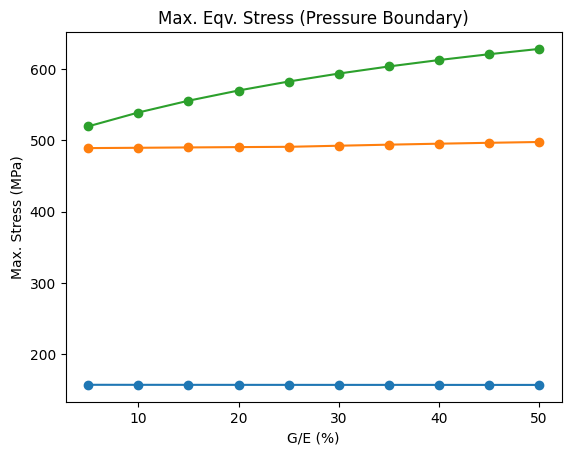

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Max. Eqv. Stress (Pressure Boundary)")
ax.set_xlabel("G/E (%)")
ax.set_ylabel("Max. Stress (MPa)")

for case in config.CASES:
    ax.plot(FRACTIONS, max_eqv_stresses[case], label=case)
    ax.scatter(FRACTIONS, max_eqv_stresses[case])

plt.show()

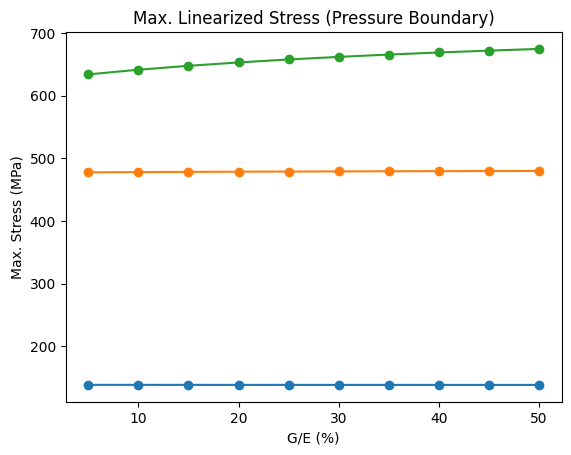

In [30]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Max. Linearized Stress (Pressure Boundary)")
ax.set_xlabel("G/E (%)")
ax.set_ylabel("Max. Stress (MPa)")

FRACTIONS = list(range(5, 51, 5))

for case in config.CASES:
    ax.plot(FRACTIONS, max_lin_stresses[case], label=case)
    ax.scatter(FRACTIONS, max_lin_stresses[case])

plt.show()

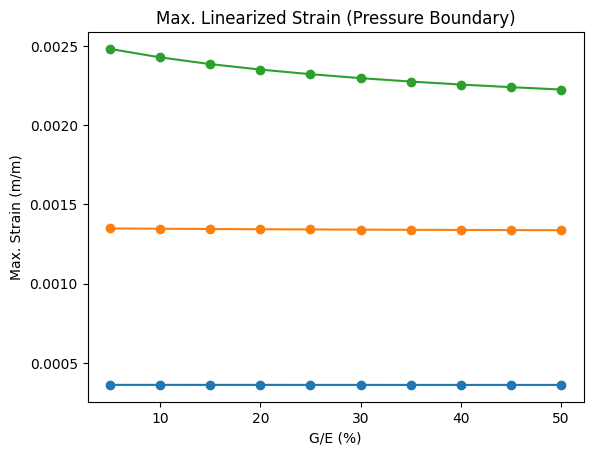

In [31]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Max. Linearized Strain (Pressure Boundary)")
ax.set_xlabel("G/E (%)")
ax.set_ylabel("Max. Strain (m/m)")

for case in config.CASES:
    ax.plot(FRACTIONS, max_lin_strains[case], label=case)
    ax.scatter(FRACTIONS, max_lin_strains[case])

plt.show()